
# Alessio Cocchieri
## Matricola: 1046067


---



# Table of Contents

* [BLIND SOURCE SEPARATION](#link1)

* [U-NET](#link2)
    * [Architecture](#link2_1)
    * [Customized U-Net](#link2_2)
    * [Build U-Net Architecture in Tensorflow](#link2_3)

* [TRAINING](#link3)
    * [Train and Validation Generator](#link3_1)
    * [Hyperparameters](#link3_2)
    * [Callbacks](#link3_3)
    * [Compile and fit](#link3_4)
    * [Training results](#link3_5)

* [EVALUATION](#link4)
    * [Results on test set](#link4_1)
    * [Plot of the results](#link4_2)

# Blind source separation
The purpose of the project is to separate an image obtained as a sum of a two images into its components. 

The two images img1 and img2 summed together come from different dataset: mnist and fashion_mnist, respectively.

No preprocessing is allowed. The network takes in input the sum img1+img2 and returns the predicted components hat_img1 and hat_img2. 

The metric used to evaluate the project is the mean squared error between predicted and ground truth images.


In [ ]:
import tensorflow as tf
from tensorflow import keras as ks
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist, fashion_mnist

import os
import numpy as np
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split

Here we load the two datasets, mnist and fashion mnist (both in grayscale).

For simplicity, the samples are padded to dimension (32,32).

In [ ]:
(mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = mnist.load_data()
print(np.shape(mnist_x_train))
(fashion_mnist_x_train, fashion_mnist_y_train), (fashion_mnist_x_test, fashion_mnist_y_test) = fashion_mnist.load_data()
#normnalize in and pad
mnist_x_train = np.pad(mnist_x_train,((0,0),(2,2),(2,2)))/255.
print(np.shape(mnist_x_train))
mnist_x_test = np.pad(mnist_x_test,((0,0),(2,2),(2,2)))/255.
fashion_mnist_x_train = np.pad(fashion_mnist_x_train,((0,0),(2,2),(2,2)))/255.
fashion_mnist_x_test = np.pad(fashion_mnist_x_test,((0,0),(2,2),(2,2)))/255.

11501568/11490434 [==============================] - 0s 0us/step
(60000, 28, 28)
4431872/4422102 [==============================] - 0s 0us/step
(60000, 32, 32)


In [ ]:
print(np.shape(mnist_x_train))

(60000, 32, 32)


Here is a simple datagenerator.

In [ ]:
def datagenerator(x1,x2,batchsize):
    n1 = x1.shape[0]
    n2 = x2.shape[0]
    while True:
        num1 = np.random.randint(0, n1, batchsize)
        num2 = np.random.randint(0, n2, batchsize)

        x_data = (x1[num1] + x2[num2]) / 2.0
        y_data = np.concatenate((x1[num1], x2[num2]), axis=2)

        yield x_data, y_data 

Let us look at some input-output pairs

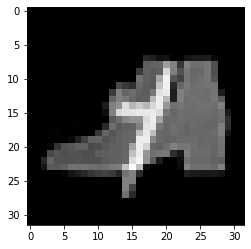

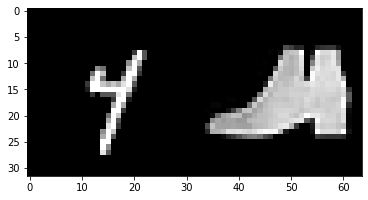

In [ ]:
x, y = next(datagenerator(mnist_x_train,fashion_mnist_x_train,1))
plt.imshow(x[0],cmap='gray', interpolation='nearest')
plt.show()
plt.imshow(y[0], cmap='gray', interpolation='nearest')
plt.show()

In [ ]:
img_shape = (32,32,1)
img_rows = 32
img_cols = 32

# U-Net   <a class="anchor" id="link2"></a>


---


## Architecture  <a class="anchor" id="link2_1"></a>
The architecture that I chose to solve the task is the one of the well-known U-Net model. While the initial research paper that introduced the U-Net architecture was to solve the task of Biomedical Image Segmentation, it was not limited to this single application. The model can still solve the most complex problems in deep learning and it showed its utlity also to solve the current Blind source separation problem. 
<br>  
In the original paper, the UNET is described as follows:  
<center><img src="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png" width="500" height="300"/></center>
  
It uses the concept of fully convolutional networks, thus it only contains Convolutional layers and does not contain any Dense layer or Flatten layers (or similar) because of which it can accept image of any size.
<br>  
The architecture can be divide into two different paths:
- **Downsampling path (encoder)**: used to capture the context in the image. The encoder is just a traditional stack of convolutional and max pooling layers. 
- **Upsampling path (decoder)**: symmetric path to the previous one which is used to enable precise localization using transposed convolutions. 


The intent of the U-Net is to capture both the features of the context as well as the localization. This process is completed successfully by the type of architecture built. The main idea of the implementation is to utilize successive contracting layers, which are immediately followed by the upsampling operators for achieving higher resolution outputs on the input images. 



## Customized U-Net <a class="anchor" id="link2_2"></a>

However, starting from the standard U-Net architecture I made some improvements to the net in order to adapt it in the best way to the current task:

- **Concatenation of output channels**: In the standard U-Net architecture, the output layer is a convolutional layer which produces a single feature map and makes use of sigmoid. In our problem, we need to separate two mixed images, therefore the output layer must have two output channels. Then the two output channels have been concatened in order to create an unique 32x64 image.

- **Increase of filters and coinvolutions before upsampling**: Before performing the upsampling step I decided to double the number of filters (from 128 to 256) and the number of coinvolutions per step (from 2 to 4). This choice has been made because we have two output channels instead of only one and it helped to reduce substantially the results the final MSE error.

- **Depthwise coinvolution**: a final Depth-wise convolution turned out to be useful to apply each filter channel only at one input channel. Therefore, it is as if I applied different convolution to each image. It gave an important contribute for the improvement of  the results.

## Build U-Net Architecture in Tensorflow <a class="anchor" id="link2_3"></a>
We can summarize the final chosen architecture in the following manner:
- 2 encoder blocks with 2 convolution per layer. Each time the numbers of filters is doubled.

- 2 decoder blocks with 4 convolution per layer. Each time the numbers of filters is halved.

- Eventually, a Depthwise-Convultion has been applied to the net before concatening the two output channels.

The **total number of parameters** turns out to be **3,684,214**

In [ ]:
def get_unet(x, out_ch, filters=64, kernel_size=(3, 3), n_layers=4, conv_per_layer=2, activation='relu'):
    
    down_layers = []    
    # Construct the encoder blocks  
    for l in range(n_layers):
        # Convolution step
        for i in range(conv_per_layer):
            x = ks.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding='same')(x)
        down_layers.append(x)
        x = ks.layers.MaxPool2D(pool_size=(2, 2), padding='same')(x)
        filters *= 2

    # Preparing the next blocks
    for i in range(conv_per_layer):
        x = ks.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding='same')(x)

    filters *= 4

    # Construct the decoder blocks   
    for l in range(n_layers):
        filters = filters // 2
        # Upsampling
        up = ks.layers.Conv2DTranspose(filters=filters, kernel_size=(2, 2), strides=2)(x)   
        # concatenating the essential features 
        down = down_layers.pop()
        x = ks.layers.concatenate([down, up])
        #convolution step
        for i in range(conv_per_layer*2):
            x = ks.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding='same')(x)

    return ks.layers.Conv2D(filters=out_ch, kernel_size=(1, 1))(x)

In [ ]:
def create_model(filters=64, n_layers=3, activation='relu'):
    tf.keras.backend.clear_session()

    # Take the image shape  
    x = ks.layers.Input(img_shape)
   
    # Get U-Net
    imgs = get_unet(x, out_ch=2, filters=filters, n_layers=n_layers, activation=activation)

    # Depth-Wise convolution
    imgs = ks.layers.DepthwiseConv2D(kernel_size=(3,3),padding='same')(imgs)

    # Store the two output channels into two different variables
    y1 = imgs[:, :, :, 0]
    y2 = imgs[:, :, :, 1]

    # Concatetanation of output channels to get unique image 32x44
    y = tf.concat([y1, y2], axis=2)
    
    model = ks.Model(x,y)
    return model

In [ ]:
model = create_model(filters=32, n_layers=2, activation='relu')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 32)   9248        ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 16, 16, 32)   0           ['conv2d_1[0][0]']               
                                                                                              

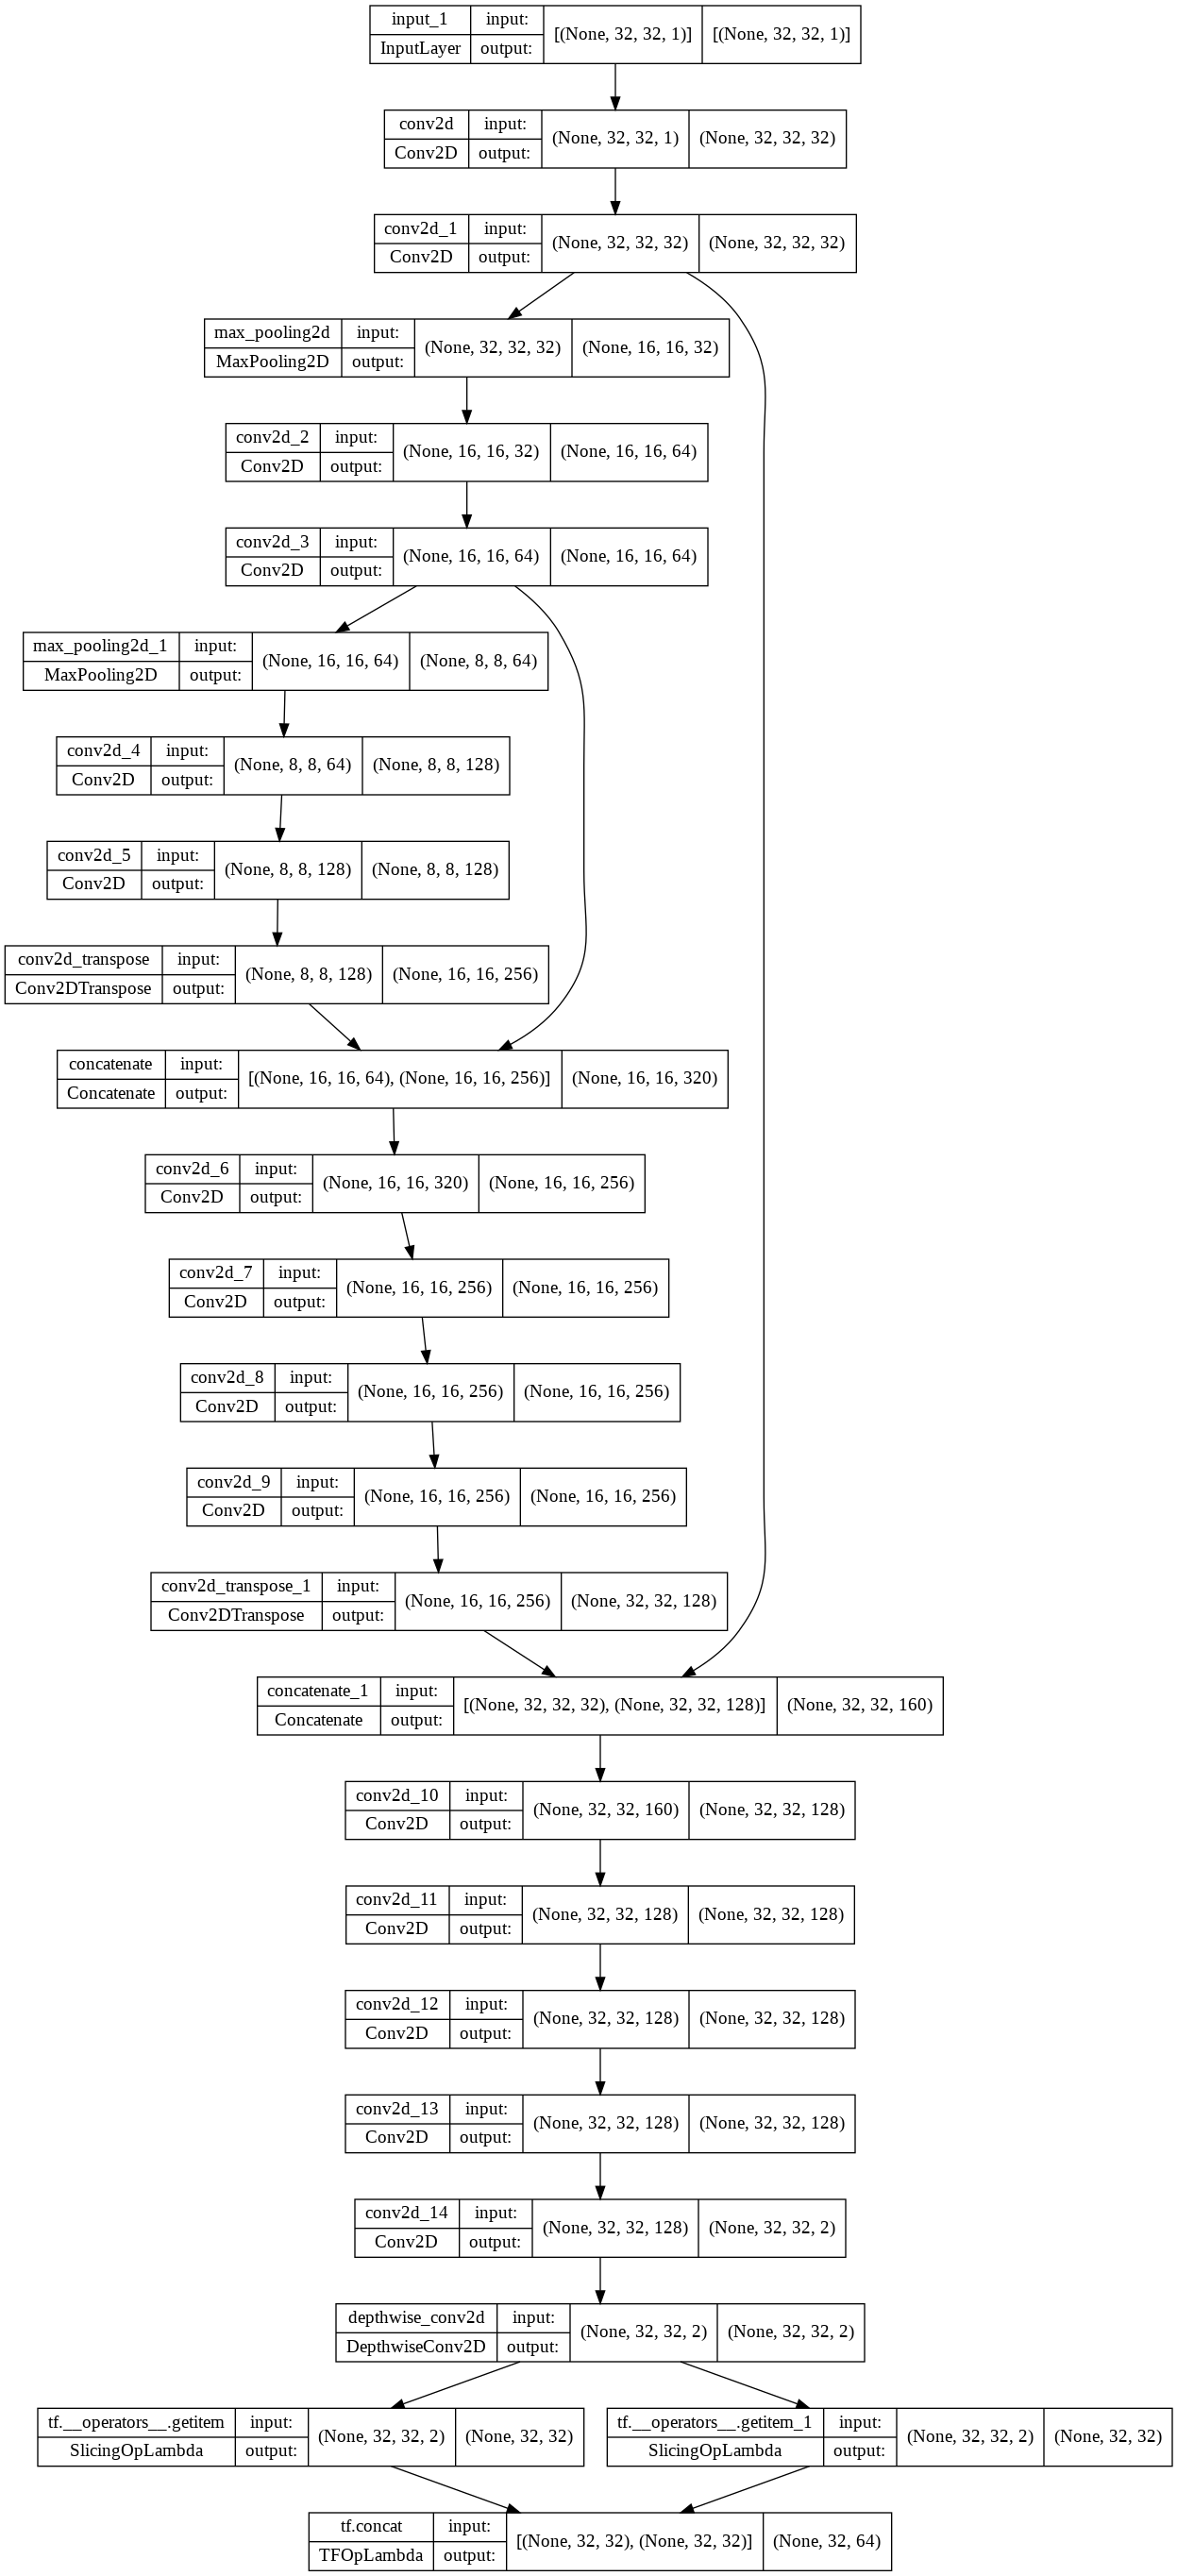

In [ ]:
ks.utils.plot_model(model=model, to_file='unet.png', show_shapes=True)

# Training <a class="anchor" id="link3"></a>

---

## Train and Validation Generator <a class="anchor" id="link3_1"></a>
After having defined a train generator, I decided to derive a validation set from each of the two train sets in order to build also a validation generator. This allow me to validate the data during the training phase and to find the best hyperparamters for the classifier.

In [ ]:
mnist_train, mnist_val = train_test_split(mnist_x_train, test_size=0.1)
fashion_mnist_train, fashion_mnist_val = train_test_split(fashion_mnist_x_train, test_size=0.1)

train_samples = mnist_train.shape[0]
val_samples = mnist_val.shape[0]

print('MNIST')
print('Train set:', mnist_train.shape)
print('Validation set:', mnist_val.shape,'\n')

print('FASHION MNIST')
print('Train set:', fashion_mnist_train.shape)
print('Validation set:', fashion_mnist_val.shape,'\n')

MNIST
Train set: (54000, 32, 32)
Validation set: (6000, 32, 32) 

FASHION MNIST
Train set: (54000, 32, 32)
Validation set: (6000, 32, 32) 



In [ ]:
batch_size = 32
train_generator = datagenerator(mnist_train, fashion_mnist_train, batch_size)
val_generator = datagenerator(mnist_val, fashion_mnist_val, batch_size)

## Hyperparameters <a class="anchor" id="link3_2"></a>

In [ ]:
loss = 'mse'
lr = 1e-3
epochs = 120
batch_size = 32
metric = 'mse'

factor = 3

steps_per_epoch = factor * train_samples // batch_size
validation_steps = factor * val_samples // batch_size

## Callbacks <a class="anchor" id="link3_3"></a>
During the training phase the following Keras callbacks have been used:

- **ReduceLROnPlateau**: reduces the Learning rate if the validation loss does not improve for 10 continues epochs.

- **ModelCheckpoint**: saves the weights only if there is improvement in validation loss.

- **BackupAndRestore**: useful during the evaluation of different models to momentarily interrupt a training and to resume it in a different moment.

In [ ]:
working_dir = 'unet'

# ReduceLROnPlateau
reduce_on_plateau_callback = ks.callbacks.ReduceLROnPlateau(
    monitor='loss', 
    min_lr=1e-5, 
    factor=0.5, 
    patience=10, 
    verbose=1, 
    mode='min')

# ModelCheckpoint
checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_mse',
    mode='min',
    save_best_only=True)

# Backup and restore 
backup_dir = os.path.join(working_dir, 'backup')
backup_callback = ks.callbacks.BackupAndRestore(backup_dir=backup_dir)

callbacks = [
    reduce_on_plateau_callback,
    backup_callback,
    model_checkpoint_callback,
]

## Compile and fit <a class="anchor" id="link3_4"></a>
Model is compiled with **Adam** optimizer and the metric is the **MSE**. The loss adopted is the MSE, as well, beacuse with respect to a possible MAE it allowed to get the best performances of the model. 

In [ ]:
optimizer = ks.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

history = model.fit(train_generator, steps_per_epoch=steps_per_epoch,
                    validation_data=val_generator, validation_steps=validation_steps,
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=callbacks)

# The model weights (that are considered the best) are loaded into the model.
model.load_weights(checkpoint_filepath)

Epoch 1/120
5062/5062 [==============================] - 151s 27ms/step - loss: 0.0045 - mse: 0.0045 - val_loss: 0.0015 - val_mse: 0.0015 - lr: 0.0010
Epoch 2/120
5062/5062 [==============================] - 135s 27ms/step - loss: 0.0013 - mse: 0.0013 - val_loss: 0.0011 - val_mse: 0.0011 - lr: 0.0010
Epoch 3/120
5062/5062 [==============================] - 134s 26ms/step - loss: 0.0010 - mse: 0.0010 - val_loss: 9.6445e-04 - val_mse: 9.6445e-04 - lr: 0.0010
Epoch 4/120
5062/5062 [==============================] - 134s 26ms/step - loss: 8.7669e-04 - mse: 8.7669e-04 - val_loss: 0.0012 - val_mse: 0.0012 - lr: 0.0010
Epoch 5/120
5062/5062 [==============================] - 133s 26ms/step - loss: 7.8137e-04 - mse: 7.8137e-04 - val_loss: 7.5250e-04 - val_mse: 7.5250e-04 - lr: 0.0010
Epoch 6/120
5062/5062 [==============================] - 134s 26ms/step - loss: 7.2965e-04 - mse: 7.2965e-04 - val_loss: 6.7224e-04 - val_mse: 6.7224e-04 - lr: 0.0010
Epoch 7/120
5062/5062 [=======================

## Training results <a class="anchor" id="link3_5"></a>
From the results we can notice that the model with the increasing number of epochs does not show any presence of overfitting. It probably happens due to the randomness of the dataset and to the huge number of samples at disposal (60000^2 samples).

In [ ]:
def display_history(history):
    loss_training = history.history['loss']
    mse_training = history.history['mse']

    loss_val = history.history['val_loss']
    mse_val = history.history['val_mse']

    # Visualize the behavior of the loss
    plt.plot(loss_training)
    plt.plot(loss_val)
    plt.grid()
    plt.title('Loss during training')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'])
    plt.show()

    # and of the accuracy
    plt.plot(mse_training)
    plt.plot(mse_val)
    plt.grid()
    plt.title('MSE during training')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'])
    plt.show()

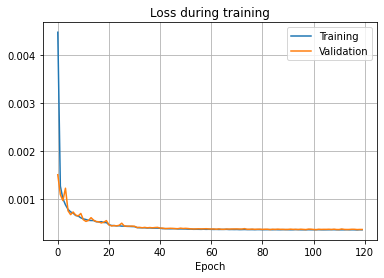

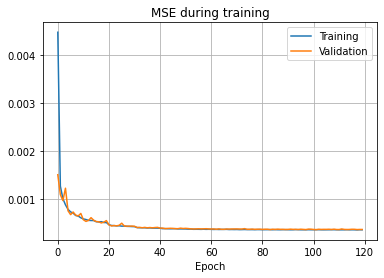

In [ ]:
display_history(history)

# Evaluation <a class="anchor" id="link4"></a>


---


## Results on test set <a class="anchor" id="link4_1"></a>
The results on the test set show that the model managed to get a **mean MSE error** of about **0.00036**. The **standard deviation** is **very low (2.0802659e-06)**, therefore there is no variance between the results of each iteration. During the 10 iterations, in fact, the MSE remains more or less always the same.

In [22]:
def mse(y_true, y_pred):
    m = ks.metrics.MeanSquaredError()
    m.update_state(y_true, y_pred)
    return m.result().numpy()

In [23]:
n_samples = 20000
test_generator = datagenerator(mnist_x_test, fashion_mnist_x_test, n_samples)

In [25]:
mse_res = []
for i in range(10):
  x,y_true = next(test_generator)
  y = model.predict(x)

  x = x.astype('float32')
  y_true = y_true.astype('float32')
  y = y.astype('float32')

  mse_res.append(mse(y_true, y))

min = np.min(mse_res)
mean = np.mean(mse_res)
std = np.std(mse_res)


print("Min error: ", min)
print("Mean error:", mean)
print("Standard deviation:", std)

Min error:  0.00036434227
Mean error: 0.0003677387
Standard deviation: 2.0802659e-06


## Plot of the results <a class="anchor" id="link4_2"></a>
As it is possible to see from the sample figures below, the predicted images and the original ones are almost the same. 

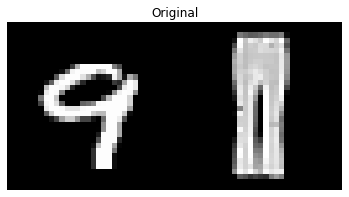

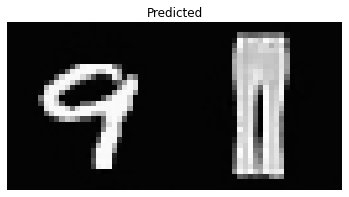

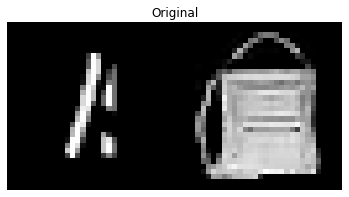

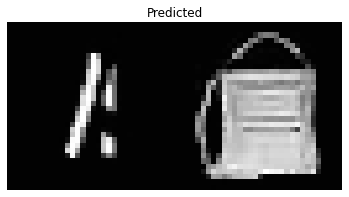

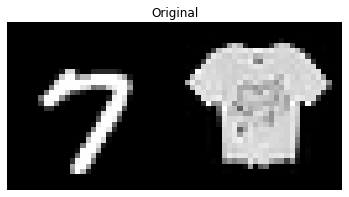

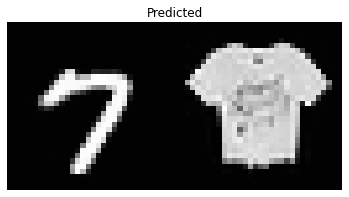

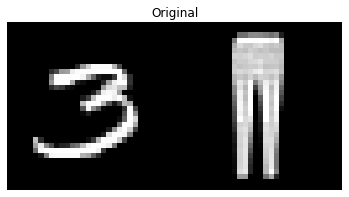

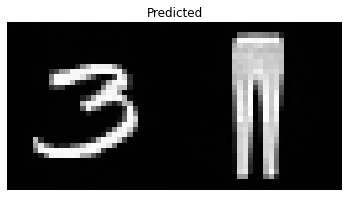

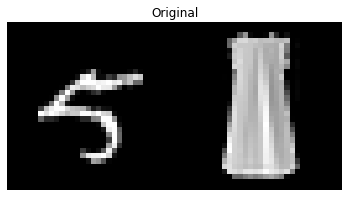

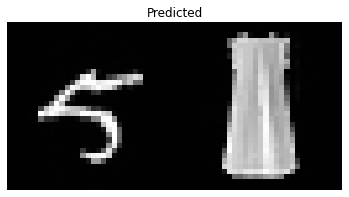

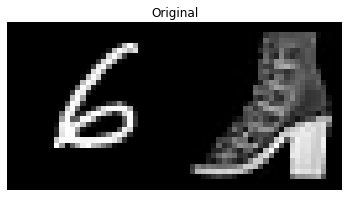

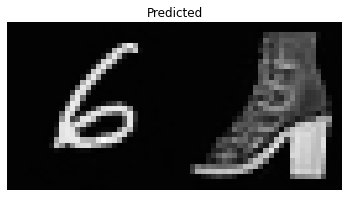

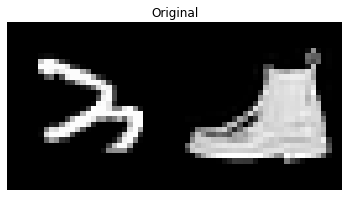

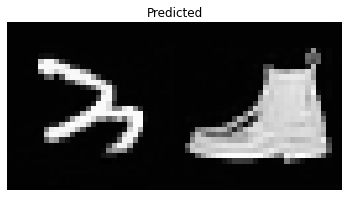

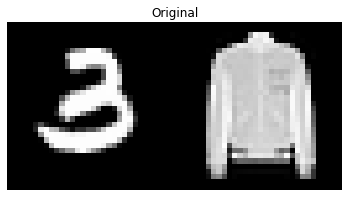

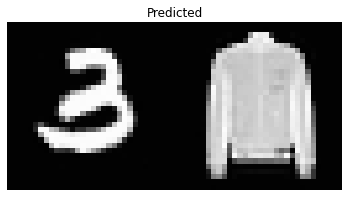

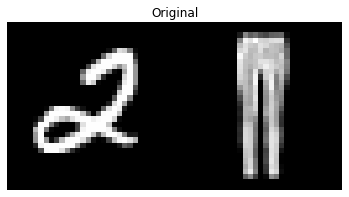

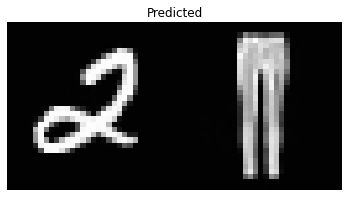

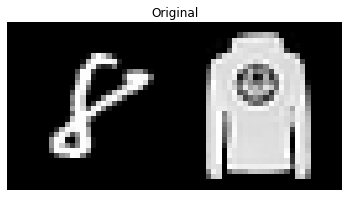

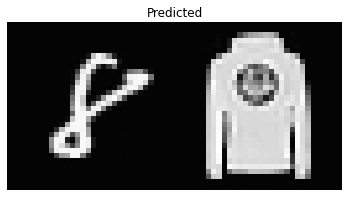

In [26]:
for i in range(10):
    plt.imshow(y_true[i], cmap='gray', interpolation='nearest')
    plt.axis('off')
    plt.title('Original')
    plt.show()

    plt.imshow(y[i], cmap='gray', interpolation='nearest')
    plt.axis('off')
    plt.title('Predicted')
    plt.show()